In [4]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 17 16:48:11 2015

@author: ruifpmaia
"""

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import mean_absolute_error
from math import sqrt
import numpy as np
import glob
import os
import csv

%matplotlib inline

In [83]:
def draw_violin(a,b,c,d,e, label, tickslabellist):
    data = [a['rmse'], b['rmse'], c['rmse'], d['rmse'], e['rmse']]
    fig = plt.figure(figsize=(9,6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 5]) 
    ax = plt.subplot(gs[1])
    ax.set_xticklabels([0] + tickslabellist, fontsize=14)
    # Add axis labels and title
    plt.xlabel(label, fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.yticks(fontsize = 14)
    plt.violinplot(data, showmedians=True)
    ax = plt.subplot(gs[0])
    ax.axes.get_xaxis().set_visible(False)
    bar_values = [a['rmse'].shape[0], b['rmse'].shape[0], c['rmse'].shape[0], d['rmse'].shape[0], e['rmse'].shape[0]]
    size_df = pd.DataFrame(bar_values)
    size_df.plot(kind='bar', ax = ax, width=0.4, legend=False)
    plt.ylabel('Rating Events', fontsize=14)
    plt.xlabel(label, fontsize=14)
    plt.yticks(fontsize = 14) 
    # add bar labels
    xx = range(len(bar_values))
    ymax = 0
    for x, y in zip(xx, bar_values):
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=14)
        if (int(y) > ymax):
            ymax = int(y)
    plt.ylim(0,1.3*ymax)
    plt.xlim(-1,5)
    plt.tight_layout()
    plt.subplots_adjust(wspace=5)


In [6]:
#dietary groups
hash_rec = {}

# Load events with Dietary Groups
# epicurious_ds15 - Rating + User + Item + Groups
with open('Analysis_Graphics\\epicurious_ds15', 'rb') as f:
    reader = csv.reader(f, delimiter='\t')
    for line in reader:
        line = map(lambda i: int(i.replace(":1","")), line) 
        # get feature id for recipeid
        fid = line[2]
        feature_id = hash_rec.get(fid, 0)
        # if null, add id and increment unique_identifier
        if ((feature_id) == 0):
            hash_rec[fid] = line[3:]
print 'Recipes with Dietary Groups:%d' % len(hash_rec)


Recipes with Dietary Groups:7997


In [7]:
#ingredients
hash_ing = {}

# Load events with Dietary Groups
# epicurious_ds8 - Rating + User + Item + Ingredients
with open('Analysis_Graphics\\epicurious_ds8', 'rb') as f:
    reader = csv.reader(f, delimiter='\t')
    for line in reader:
        line = map(lambda i: int(i.replace(":1","")), line) 
        # get feature id for recipeid
        fid = line[2]
        feature_id = hash_ing.get(fid, 0)
        # if null, add id and increment unique_identifier
        if ((feature_id) == 0):
            hash_ing[fid] = line[3:]
print 'Recipes with Ingredients:%d' % len(hash_ing)

Recipes with Ingredients:7997


In [8]:
#cuisines
hash_cui = {}

# Load events with Dietary Groups
# epicurious_ds14 - Rating + User + Item + Categories
with open('Analysis_Graphics\\epicurious_ds14', 'rb') as f:
    reader = csv.reader(f, delimiter='\t')
    for line in reader:
        line = map(lambda i: int(i.replace(":1","")), line) 
        # get feature id for recipeid
        fid = line[2]
        feature_id = hash_cui.get(fid, 0)
        # if null, add id and increment unique_identifier
        if ((feature_id) == 0):
            hash_cui[fid] = line[3:]
print 'Recipes with Cuisines:%d' % len(hash_cui)

Recipes with Cuisines:7997


In [9]:
dgres_df = pd.DataFrame()
cuires_df = pd.DataFrame()
ingres_df = pd.DataFrame()
epi6_fd = pd.DataFrame()


#epicurious_ds6 - Rating + User + Item + AvgRatUser + AvgRatItem
#Load epicurious_ds6 to evaluate
ds_filename = "Analysis_Graphics\\epicurious\\ProcessedInput\\epicurious_ds6.*.test.libfm"
for in_file in glob.glob(ds_filename):
    # open corresponding input file - k5
    res_file = in_file.replace("ProcessedInput", "ProcessedOutput").replace("test.libfm", "k5.txt")  
    # read files
    index = 0
    epi6_rec  = pd.read_table(res_file, sep='\t', skip_blank_lines=True, header=None)
    print 'Read file:' + in_file
    with open(in_file, 'rb') as f:
        reader = csv.reader(f, delimiter='\t')
        for fvec in reader:        
            #get rec_id
            rec_id = int(fvec[2].replace(":1",""))
            #get dietary groups 
            dg = hash_rec.get(rec_id, 0)
            #get cuisines
            cuigrp = hash_cui.get(rec_id, 0)
            #get ingredients
            inggrp = hash_ing.get(rec_id, 0)
            #calculate MAE, calculate RMSE
            mae = mean_absolute_error([int(fvec[0])], [epi6_rec.get_value(index,0)])
            rmse = sqrt(mae)
            if (dg == 0):
                print "ERROR<dietary group not found>:Recipe %s" % rec_id
                break
            elif (len(dg) > 0):
                #create entry for each dietary group
                for dg_id in dg:                
                    dgres_df = dgres_df.append([(dg_id, rmse, mae)])      
            if (cuigrp == 0):
                print "ERROR<cuisines not found>:Recipe %s" % rec_id
                break
            elif (len(cuigrp) > 0):
                #create entry for each cuisine
                for cuisine_id in cuigrp:                
                    cuires_df = cuires_df.append([(cuisine_id, rmse, mae)])    
            if (inggrp == 0):
                print "ERROR<ingredients not found>:Recipe %s" % rec_id
                break
            elif (len(inggrp) > 0):
                #create entry for each cuisine
                for ingredient_id in inggrp:                
                    ingres_df = ingres_df.append([(ingredient_id, rmse, mae)])    
            # User and item df
            epi6_fd = epi6_fd.append([(fvec[0],fvec[1],fvec[2],rmse,mae)])
            index += 1
    print 'Cuisines DF final shape:' + str(cuires_df.shape)
    print 'Dietary Groups DF final shape:' + str(dgres_df.shape) 
    print 'Ingredients DF final shape:' + str(ingres_df.shape) 
    print 'User and Item DF final shape:' + str(epi6_fd.shape) 



Read file:Analysis_Graphics\epicurious\ProcessedInput\epicurious_ds6.2.test.libfm
Cuisines DF final shape:(9206, 3)
Dietary Groups DF final shape:(10535, 3)
Ingredients DF final shape:(60321, 3)
User and Item DF final shape:(14694, 5)
Read file:Analysis_Graphics\epicurious\ProcessedInput\epicurious_ds6.3.test.libfm
Cuisines DF final shape:(18654, 3)
Dietary Groups DF final shape:(21046, 3)
Ingredients DF final shape:(121049, 3)
User and Item DF final shape:(29388, 5)
Read file:Analysis_Graphics\epicurious\ProcessedInput\epicurious_ds6.4.test.libfm
Cuisines DF final shape:(28041, 3)
Dietary Groups DF final shape:(31538, 3)
Ingredients DF final shape:(181625, 3)
User and Item DF final shape:(44081, 5)
Read file:Analysis_Graphics\epicurious\ProcessedInput\epicurious_ds6.1.test.libfm
Cuisines DF final shape:(37211, 3)
Dietary Groups DF final shape:(42133, 3)
Ingredients DF final shape:(242173, 3)
User and Item DF final shape:(58775, 5)
Read file:Analysis_Graphics\epicurious\ProcessedInput\

### User analysis

In [92]:
epi6_fd.columns=['rating','userid','itemid','rmse','mae']
epi_gb_user = epi6_fd.groupby('userid')
# group users by rating count
a = epi_gb_user.filter(lambda x: len(x) < 10)
print a.shape
b = epi_gb_user.filter(lambda x: 10 <= len(x) < 20)
print b.shape
c = epi_gb_user.filter(lambda x: 20 <= len(x) < 30)
print c.shape
d = epi_gb_user.filter(lambda x: 30 <= len(x) < 40)
print d.shape
e = epi_gb_user.filter(lambda x: len(x) >= 40)
print e.shape

(31927, 5)
(25443, 5)
(11275, 5)
(3834, 5)
(989, 5)


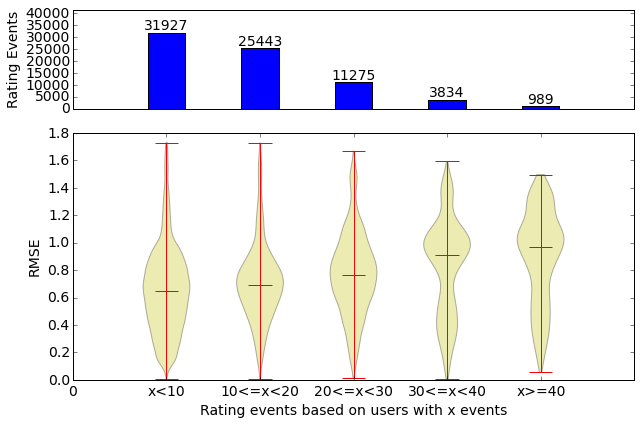

In [93]:
draw_violin(a,b,c,d,e,'Rating events based on users with x events', ['x<10','10<=x<20','20<=x<30','30<=x<40','x>=40'])

### Item analysis

In [94]:
epi_gb_item = epi6_fd.groupby('itemid')
# group users by rating count
a = epi_gb_item.filter(lambda x: len(x) < 10)
print a.shape
b = epi_gb_item.filter(lambda x: 10 <= len(x) < 20)
print b.shape
c = epi_gb_item.filter(lambda x: 20 <= len(x) < 30)
print c.shape
d = epi_gb_item.filter(lambda x: 30 <= len(x) < 40)
print d.shape
e = epi_gb_item.filter(lambda x: len(x) >= 40)
print e.shape

(32514, 5)
(23062, 5)
(8439, 5)
(4397, 5)
(5056, 5)


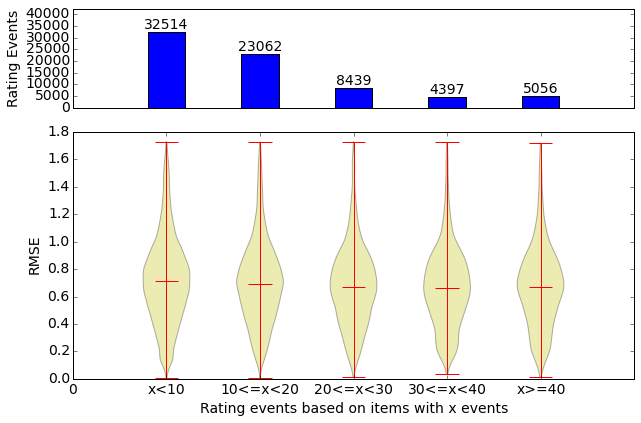

In [95]:
draw_violin(a,b,c,d,e,'Rating events based on items with x events', ['x<10','10<=x<20','20<=x<30','30<=x<40','x>=40'])

### Cuisine Type analysis

In [96]:
cuires_df.columns=['cid','rmse','mae']
epi_gb_cui = cuires_df.groupby('cid')
# cuisine types by event count
a = epi_gb_cui.filter(lambda x: len(x) < 500)
print a.shape
b = epi_gb_cui.filter(lambda x: 500 <= len(x) < 2000)
print b.shape
c = epi_gb_cui.filter(lambda x: 2000 <= len(x) < 5000)
print c.shape
d = epi_gb_cui.filter(lambda x: 5000 <= len(x) < 10000)
print d.shape
e = epi_gb_cui.filter(lambda x: len(x) >= 10000)
print e.shape

(300, 3)
(4603, 3)
(7808, 3)
(21276, 3)
(12642, 3)


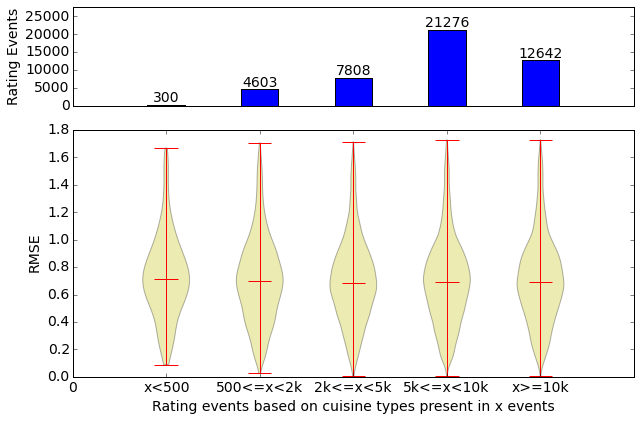

In [97]:
draw_violin(a,b,c,d,e,'Rating events based on cuisine types present in x events', ['x<500','500<=x<2k','2k<=x<5k','5k<=x<10k','x>=10k'])

### Dietary Group analysis

In [98]:
dgres_df.columns=['dgid','rmse','mae']
epi_gb_dg = dgres_df.groupby('dgid')
# dietarey groups by event count
a = epi_gb_dg.filter(lambda x: len(x) < 500)
print a.shape
b = epi_gb_dg.filter(lambda x: 500 <= len(x) < 2000)
print b.shape
c = epi_gb_dg.filter(lambda x: 2000 <= len(x) < 5000)
print c.shape
d = epi_gb_dg.filter(lambda x: 5000 <= len(x) < 10000)
print d.shape
e = epi_gb_dg.filter(lambda x: len(x) >= 10000)
print e.shape

(6821, 3)
(10748, 3)
(8665, 3)
(6932, 3)
(19607, 3)


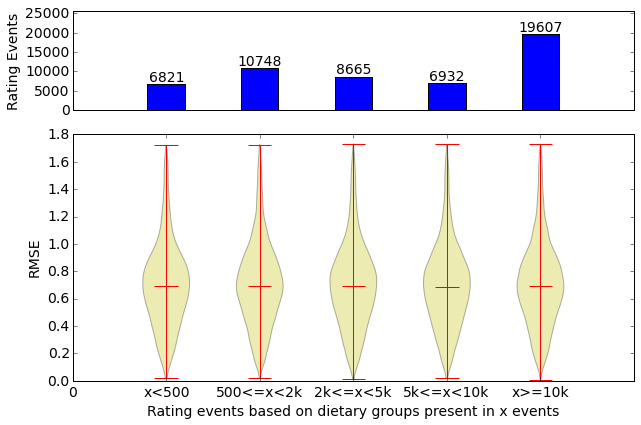

In [99]:
draw_violin(a,b,c,d,e,'Rating events based on dietary groups present in x events', ['x<500','500<=x<2k','2k<=x<5k','5k<=x<10k','x>=10k'])

### Ingredient analysis

In [100]:
ingres_df.columns=['ingid','rmse','mae']
epi_gb_ing = ingres_df.groupby('ingid')
# ingredient groups by event count
a = epi_gb_ing.filter(lambda x: len(x) < 500)
print a.shape
b = epi_gb_ing.filter(lambda x: 500 <= len(x) < 2000)
print b.shape
c = epi_gb_ing.filter(lambda x: 2000 <= len(x) < 5000)
print c.shape
d = epi_gb_ing.filter(lambda x: 5000 <= len(x) < 7000)
print d.shape
e = epi_gb_ing.filter(lambda x: len(x) >= 7000)
print e.shape

(28056, 3)
(101885, 3)
(83018, 3)
(48134, 3)
(41942, 3)


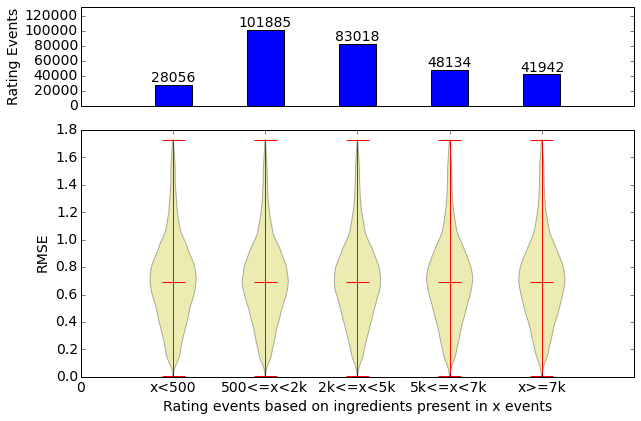

In [101]:
draw_violin(a,b,c,d,e,'Rating events based on ingredients present in x events', ['x<500','500<=x<2k','2k<=x<5k','5k<=x<7k','x>=7k'])